# [Add] Comparison to the classical method (tick library)

## Multivariate exponential Hawkes process

We consider the multivariate exponential Hawkes process $N_t = (N^1_t, \dots, N^d_t)$ whose intensity is

\[
	\lambda^i_t(\vartheta^*) = \mu_i + \sum_{j=1}^d \int_{[0,t)} \alpha_{ij}e^{-(t-s)} N^j(ds) \bigg|_{\vartheta = \vartheta^*}, \quad i = 1,\dots d, \nonumber
\]

where $\vartheta = \big(\{\alpha_{ij}\}_{ij}, \{\mu_i\}_i \big) \in \Xi \subset \mathbb{R}_+^{d^2} \times \mathbb{R}_{>0}^{d}$ is a parameter and $\vartheta^*= \big( \{\alpha^*_{ij}\}_{ij}, \{\mu^*_i\}_i \big) \in \Xi$ is the true value.
We note that the decay parameter is given. ( $\beta_{ij} = 1.0$ for all $i, j = 1, \dots, 4$ )

### Example : 4-dim exponential Hawkes process
Let $N_t = (N^1_t ,N^2_t, N^3_t, N^4_t)$ be a $4$-dimensional exponential Hawkes process with the following parameters:

\[
	\mu^* = (0.05, 0.05, 0.05), \ \
	\alpha^* = \left(
		\begin{array}{ccc}
            0.15 & 0 & 0 & 0\\
            0.15 & 0 & 0 & 0\\
            0 & 0.1 & 0.1 & 0.1\\
            0 & 0.1 & 0.1 & 0.1
		\end{array}
		\right) \nonumber
\]

## Libraries and Functions

In [1]:
import numpy as np
from scipy import optimize, integrate
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tick.plot import plot_hawkes_kernel_norms
from tick.hawkes import HawkesADM4, HawkesExpKern, SimuHawkesExpKernels, SimuHawkesMulti
from tqdm.notebook import tqdm
import time

In [2]:
def NumOfZero(poeList):
    for i in range(dim, len(poeList[0])):
        print(i, ":", np.sum(np.array(poeList)[:,i]<=1.0e-8), "( ", np.sum(np.array(poeList)[:,i]<=1.0e-8)/3, " %)")
def SquaredError(poeList, paramsVector):
    for i in range(len(poeList[0])):
        sq_ave =  np.mean((np.array(poeList)[:,i] - paramsVector[i])**2)
        print(i, "(" , paramsVector[i], ") :", sq_ave, "(", format(sq_ave,'.2e'), ")")
def GEMHP_Hist(data, dim, title="Histgram", SavePath=""):
    FigColNum = dim+1
    fig = plt.figure(figsize=(20,15))
    plt.subplots_adjust(top=0.93, bottom = 0.2, hspace=0.3, wspace=0.2)
    gs = gridspec.GridSpec(dim, FigColNum)

    for i in range(dim):
        ax = fig.add_subplot(gs[i,0])
        plt.subplot(gs[i,0])
        MuData = np.array(data).T[i]
        ax.hist(MuData, bins=25, color="green")
        plt.xlabel(r'$ \mu_{%d} $' %(i+1), fontsize=20)
        ax.grid()     
    for i in range(dim):
        for j in range(dim):            
            ax = fig.add_subplot(gs[i,1+j])
            plt.subplot(gs[i,1+j])
            AlphaData = np.array(data).T[dim+dim*i+j]
            ax.hist(AlphaData, bins=25, color="red")
            plt.xlabel(r'$ \alpha_{%d%d} $' %((i+1), (j+1)), fontsize=20)
            ax.grid()      
        
    fig.suptitle(title, fontsize=30)
    plt.show()
    if SavePath != "" : fig.savefig(SavePath)
    return None

## Simulate Data

In [3]:
dim = 4  # dimension of the Hawkes process
beta = 1.0
mu = np.ones(4) * .05
alpha = np.array(
    [[0.15, 0 , 0 , 0],
     [0.15, 0 , 0 , 0],
     [0, 0.1 , 0.1 , 0.1],
     [0, 0.1 , 0.1 , 0.1]])
MatBeta = np.ones((dim, dim))
t_max = 3000
MC = 300
paramsVector = np.concatenate([mu, alpha.reshape(1, -1)[0]])

In [4]:
data = []
for i in range(MC):
    model = SimuHawkesExpKernels(adjacency=alpha, decays=beta, baseline=mu, end_time=t_max, verbose=False, seed=i)
    model.simulate()
    data.append(model.timestamps)

# A mix of Lasso and Nuclear regularization method

The log-likelihood function for the Hawkes process:

\[
    l_T(\vartheta) = \sum_{i=1}^d \left\{ \int_0^T \log \lambda^i_t(\vartheta)N^i(dt) - \int_0^T \lambda^i_t( \vartheta)dt \right\} \nonumber
\]

A mix of Lasso and nuclear regularization method is given by

\[
	\tilde{\vartheta}_T  \in argmin_{\vartheta \in \Xi} \Big[ -l_T(\vartheta) + C \big\{ (1-\rho) \| (\alpha_{ij})_{i,j} \|_* + \rho \| (\alpha_{ij})_{i,j} \|_1 \big\} \Big]. \nonumber
\]

where $C$ and $\rho$ are hyper parameters, $\| \cdot \|_*$ is the nuclear norm of a matrix, which is defined to be the sum of its singular value, and $\| \cdot \|_1$ is the $L^1$ norm, see Zhou, K. et al. (2013). Learning Social Infectivity in Sparse Low-rank Networks Using Multi-dimensional Hawkes Processes. In AISTATS, Vol.31, 641-649.

We set $C = 1000$ and $\rho = 0.5$.

In [5]:
C=1000
rho=0.5
learner = HawkesADM4(decay=beta, C=C, lasso_nuclear_ratio=rho)
lneList = []
lneErrorList = []

for i in range(MC):
    learner.fit(data[i])
    lne = np.concatenate([learner.baseline, learner.adjacency.reshape(1, -1)[0]])
    lneList.append(lne)
    lneErrorList.append(np.sqrt(t_max)*(lne - paramsVector))

●Percentage of estimated to be zero.
4 : 0 (  0.0  %)
5 : 121 (  40.333333333333336  %)
6 : 121 (  40.333333333333336  %)
7 : 120 (  40.0  %)
8 : 0 (  0.0  %)
9 : 131 (  43.666666666666664  %)
10 : 119 (  39.666666666666664  %)
11 : 121 (  40.333333333333336  %)
12 : 96 (  32.0  %)
13 : 0 (  0.0  %)
14 : 0 (  0.0  %)
15 : 0 (  0.0  %)
16 : 125 (  41.666666666666664  %)
17 : 0 (  0.0  %)
18 : 0 (  0.0  %)
19 : 0 (  0.0  %)

●Average of squared errors.
0 ( 0.05 ) : 2.7062548531492556e-05 ( 2.71e-05 )
1 ( 0.05 ) : 2.1655301649157325e-05 ( 2.17e-05 )
2 ( 0.05 ) : 2.688443410111803e-05 ( 2.69e-05 )
3 ( 0.05 ) : 2.5224594629138884e-05 ( 2.52e-05 )
4 ( 0.15 ) : 0.0013807256537558524 ( 1.38e-03 )
5 ( 0.0 ) : 0.0002785205741351358 ( 2.79e-04 )
6 ( 0.0 ) : 0.0002668420752179094 ( 2.67e-04 )
7 ( 0.0 ) : 0.00027657257257076103 ( 2.77e-04 )
8 ( 0.15 ) : 0.0014701884701899632 ( 1.47e-03 )
9 ( 0.0 ) : 0.00033890379283837236 ( 3.39e-04 )
10 ( 0.0 ) : 0.00021453631797310117 ( 2.15e-04 )
11 ( 0.0 ) : 0.

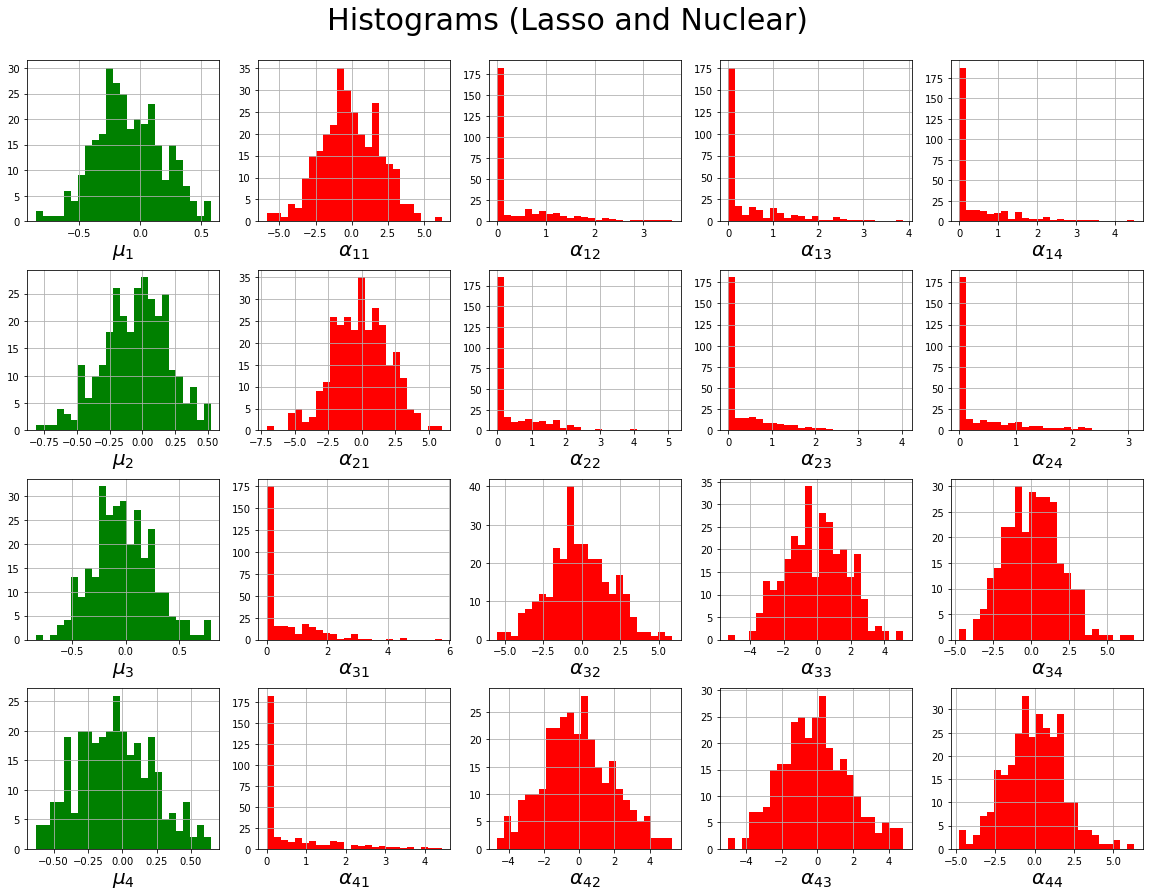

In [6]:
print("●Percentage of estimated to be zero.")
NumOfZero(lneList)
print("\n●Average of squared errors.")
SquaredError(lneList, paramsVector)

title = r'Histograms (Lasso and Nuclear)'
SavePath = 'POE/add_LNE_AN_T=%d_MC=%d.eps'  %(t_max, MC)
GEMHP_Hist(lneErrorList, dim, title, SavePath)

# Elastic Net

The least-squares function for the Hawkes process:

\[
    R_T(\vartheta) = \frac{1}{T} \sum_{i=1}^d \left\{ \int_0^T \big(\lambda^i_t(\vartheta) \big)^2 dt - 2 \int_0^T \lambda^i_t(\vartheta) N^i(dt) \right\} \nonumber
\]

te elastic net estimator is given by

\[
	\tilde{\vartheta}_T  \in argmin_{\vartheta \in \Xi} \Big[ R_T(\vartheta) + C \big\{ (1-\rho) \| (\alpha_{ij})_{i,j} \|_1 + \rho \| (\alpha_{ij})_{i,j} \|_2 \big\} \Big]. \nonumber
\]

where $C$ and $\rho$ are hyper parameters, $\| \cdot \|_1$ and $\| \cdot \|_2$ are the $L^1$ and $L^2$ norm respectively.

We set $C = 1000$ and $\rho = 0.95$.

In [7]:
C=1000
rho=0.95
learner = HawkesExpKern(decays=beta, penalty='elasticnet', C=C, elastic_net_ratio=rho)
eneList = []
eneErrorList = []

for i in range(MC):
    learner.fit(data[i])
    ene = np.concatenate([learner.baseline, learner.adjacency.reshape(1, -1)[0]])
    eneList.append(ene)
    eneErrorList.append(np.sqrt(t_max)*(ene - paramsVector))

●Percentage of estimated to be zero.
4 : 0 (  0.0  %)
5 : 170 (  56.666666666666664  %)
6 : 179 (  59.666666666666664  %)
7 : 183 (  61.0  %)
8 : 0 (  0.0  %)
9 : 181 (  60.333333333333336  %)
10 : 182 (  60.666666666666664  %)
11 : 180 (  60.0  %)
12 : 165 (  55.0  %)
13 : 2 (  0.6666666666666666  %)
14 : 0 (  0.0  %)
15 : 0 (  0.0  %)
16 : 173 (  57.666666666666664  %)
17 : 0 (  0.0  %)
18 : 0 (  0.0  %)
19 : 0 (  0.0  %)

●Average of squared errors.
0 ( 0.05 ) : 2.7061543421121152e-05 ( 2.71e-05 )
1 ( 0.05 ) : 2.1366487451005035e-05 ( 2.14e-05 )
2 ( 0.05 ) : 3.0634185950743314e-05 ( 3.06e-05 )
3 ( 0.05 ) : 2.7615413202815377e-05 ( 2.76e-05 )
4 ( 0.15 ) : 0.0017317671011917524 ( 1.73e-03 )
5 ( 0.0 ) : 0.00027099356367972315 ( 2.71e-04 )
6 ( 0.0 ) : 0.0002324382728565023 ( 2.32e-04 )
7 ( 0.0 ) : 0.00025592857930586716 ( 2.56e-04 )
8 ( 0.15 ) : 0.0018082741930422431 ( 1.81e-03 )
9 ( 0.0 ) : 0.00023752621975862178 ( 2.38e-04 )
10 ( 0.0 ) : 0.00018764132970828354 ( 1.88e-04 )
11 ( 0.0 ) 

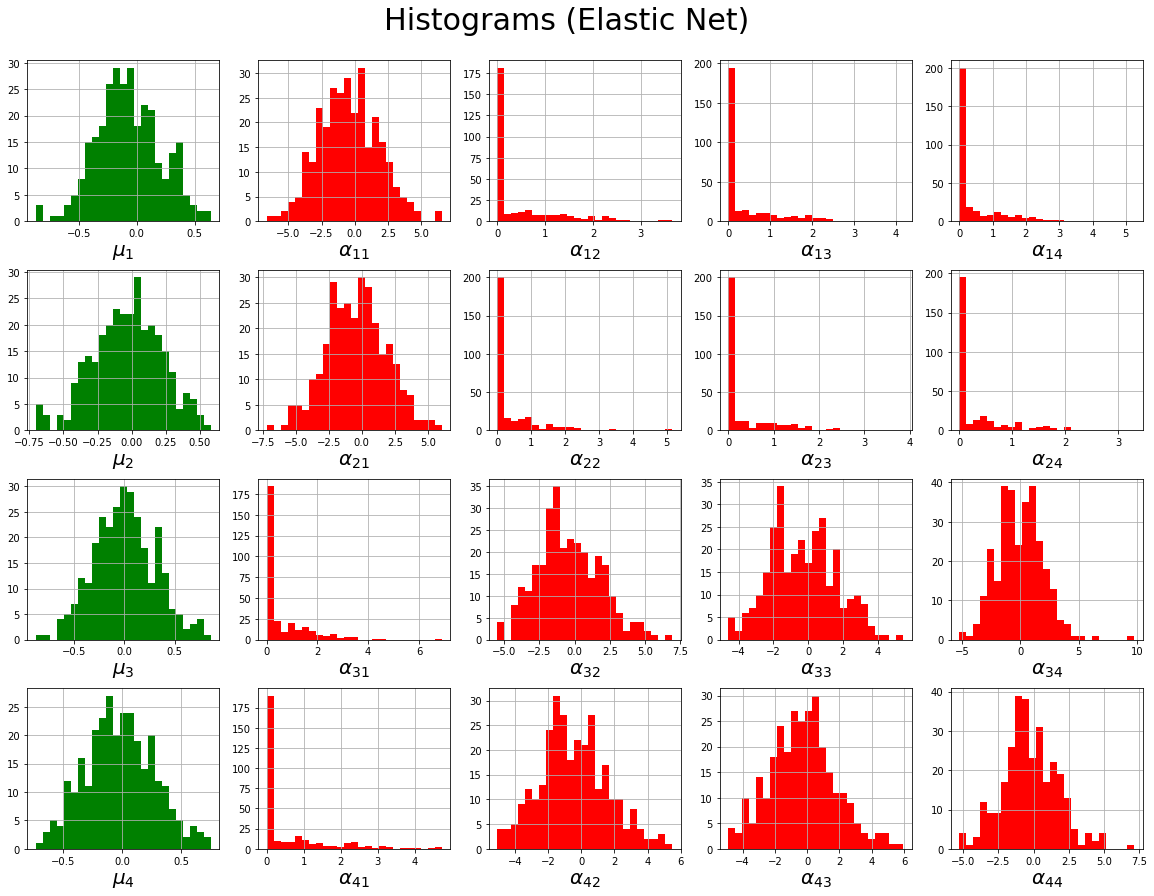

In [8]:
print("●Percentage of estimated to be zero.")
NumOfZero(eneList)
print("\n●Average of squared errors.")
SquaredError(eneList, paramsVector)

title = r'Histograms (Elastic Net)'
SavePath = 'POE/add_ENE_AN_T=%d_MC=%d.eps'  %(t_max, MC)
GEMHP_Hist(eneErrorList, dim, title, SavePath)

# P-O Estimator

In the P-O method, the estimation is done in three steps.


Step 1 : We obtain the first estimator of $\vartheta$ by

\[
    \big( \tilde{\theta}^0_T, \tilde{\theta}^1_T, \tilde{\nu}^0_T, \tilde{\nu}^1_T \big) = argmin_{\vartheta \in \Xi} l_T(\vartheta).\nonumber
\]
        
Step 2 : We obtain the second estimator of $(\theta^0, \nu^0)$ by

\[
	\big( \hat{\theta}^{0,(q)}_T, \hat{\nu}^{0,(q)}_T \big) = argmin_{ (\theta^0, \nu^0 ) \in \bar{\Theta}^0 \times \bar{\mathcal{N}}^0} Q^{(q)}_T(\theta^0, \nu^0).\nonumber
\]
        
Step 3 : We obtain the third estimator of $\vartheta$ by

\[
    \big( \check{\theta}^0_T, \check{\theta}^1_T, \check{\nu}^0_T, \check{\nu}^1_T \big) = argmin_{ \vartheta \in \hat{\Theta}^0_T \times \Theta^1 \times \hat{\mathcal{N}}^0_T \times \mathcal{N}^1} l_T(\vartheta),\nonumber
\]
        
where $\hat{\Theta}^0_T = \big\{\theta^0 \in \bar{\Theta}^0 \big| \theta^0_j = 0, j \in \hat{\mathcal{J}}^0_T \big\}, \hat{\mathcal{J}}^0_T = \big\{ j = 1, \dots, p_0 \big| \hat{\theta}^{0, (q)}_j = 0 \big\}, \hat{\mathcal{N}}^0_T = \big\{\nu^0 \in \bar{\mathcal{N}}^0 \big| \nu^0_j = 0, j \in \hat{\mathcal{K}}^0_T \big\}$ and $\hat{\mathcal{K}}^0_T = \big\{ j = 1, \dots, n_0 \big| \hat{\nu}^{0, (q)}_j = 0 \big\}$.
The objective function $Q^{(q)}_T(\theta^0, \nu^0)$ is constructed by using the first estimators $\tilde{\theta}^0_T, \tilde{\nu}^0_T$ as below.

\[
	Q^{(q)}_T(\theta^0, \nu^0) = \sum_{j=1}^{p_0} \Big( \big( \theta^0_j - \tilde{\theta}^0_j \big)^2 + \kappa^{\theta}_j | \theta_j |^q \Big) +  \sum_{j=1}^{n_0} \Big( \big( \nu^0_j - \tilde{\nu}^0_j \big)^2 +\kappa^{\nu}_j  | \nu_j |^q \Big) \nonumber
\]

where $q \in (0, 1],  \kappa^{\theta}_j = \frac{T^{-\frac{1+a}{2}}}{\big| \tilde{\theta}_j + T^{-\frac{1}{2}} \big|^{\gamma}},  \kappa^{\nu}_j = \frac{T^{-\frac{1+a}{2}}}{\big| \tilde{\nu}_j + T^{-\frac{1}{2}} \big|^{\gamma}}, \gamma > -(1-q)$ and $a \in (1-q-\gamma, 0)$.

We set $\gamma=1, a=0.5$ and $q=1$.

In [9]:
## Params Cast w.r.t. Hawkes
def ParamsToVector(params):
    ## Initial Eps is ignored
    mu = params[0]
    alpha = params[1].reshape(1, -1)[0]
    return np.concatenate([mu, alpha])  
def ParamsToList(paramsVector, dim):
    mu = paramsVector[:dim]
    alpha = paramsVector[dim:dim+dim**2].reshape(dim, dim)
    return [mu, alpha]

# Loglikelihood for No Mark Process (beta given)
def kernel_free(t, s, beta):
    kernel = np.exp(-beta*(t - s))
    return kernel
def LogLikelihood(paramsVector, args):
    time, dim, t_max, _beta = args
    _mu, _alpha = ParamsToList(paramsVector, dim)

    loglik = []
    
    # loglik_iを計算していく
    for i in range(dim):
        Ai = 0 # log( intensity^i_{t[i][z]} ) = log( mu[i] + sum_{j=1 ...,dim} sum_{k : t[i][z] > t[j][k]} alpha[i][j]*exp(-beta[i][j]*(t[i][z]-t[j][k])) )
        Bi = 0 # sum_{k=0,...,t[j][-1]} (alpha[i][j]/beta[i][j])*(exp(-beta[i][j]*(t_max-t[j][k])) -1)
        for n in range(len(time[i]))[:-1]:
            intensity = _mu[i]
            for j in range(dim):
                num = np.sum(time[j][:]<time[i][n])
                dtime = time[i][n]-time[j][:num]
                exptB = np.exp(-_beta[i][j]*dtime)
                intensity += _alpha[i][j]*np.sum(exptB)          
            Ai += np.log(intensity)
        for j in range(dim):
            Bi += (-1)*(_alpha[i][j]/_beta[i][j])*np.sum(kernel_free(t_max, time[j][:-1], _beta[i][j])-1)
        loglik.append(Ai - (_mu[i]*t_max + Bi))
    return -np.sum(loglik)

# Step. 1. : Estimate MLE by LogLikelihood
# Step. 2.a. : Extract possibly zero components from MLE by LSAParams
# Step. 2.b. : Estimate LSAE by LSA
# Step 3.a. : Extract zero components from LSAE by LSAParams
# Step 3.b : Estimate P-O by ElimLogLikelihood

# Extract possibly zero components (mu, m) for ElimZeroParams
def LSAParams(paramsVector, dim, bounds):
    LSAParamsVector = paramsVector[dim:]
    low_bd = bounds[0][dim:]
    up_bd = bounds[1][dim:]
    LSABounds = [low_bd, up_bd]
    return LSAParamsVector, LSABounds
# Reconstruct full parameter from LSAParamsVector.
def ReconstLSAParams(LSAParamsVector, paramsVector, dim):
    ParamsVector = np.concatenate([paramsVector[:dim], LSAParamsVector])
    return ParamsVector
# Eliminate zero components
def ElimZeroParams(paramsVector, bounds):
    nonZeroId = paramsVector!=0
    elimParamsVector = paramsVector[nonZeroId]
    low_bd = bounds[0][nonZeroId].tolist()
    up_bd = bounds[1][nonZeroId]
    elimBounds = [low_bd, up_bd]
    return elimParamsVector, nonZeroId, elimBounds
# Reconstruct full parameter from elimParamsVector.
def ReconstZeroParams(elimParamsVector, nonZeroId):
    paramsVector = np.array(nonZeroId, float) # Zero params are zero
    paramsVector[nonZeroId] = elimParamsVector
    return paramsVector
# Objective function (Least Square Approximation)
def LSA(zeroParamsVector, args): 
    zeroPreEstVector, dim, t_max, gamma, a, q = args # where zeroPreEstVector = LSAParams(preEstVector, dims)
    kappa = t_max**(-(1+a)/2)*(zeroPreEstVector+1.0e-5*t_max**(-1/2))**(-gamma) # 罰則項係数．
    lsa = np.sum((zeroParamsVector-zeroPreEstVector)**2 + kappa*zeroParamsVector**q)
    return lsa
# Objective function (LogLikelihood)
def ElimLogLikelihood(elimParamsVector, args):
    arrivals, dim, t_max, beta, nonZeroId = args
    paramsVector = ReconstZeroParams(elimParamsVector, nonZeroId)
    return LogLikelihood(paramsVector, [arrivals, dim, t_max, beta])
# Step1: LSE -> Step2: LSA -> Step3: QMLE
# bounds1, bounds2はlistで渡し，full paramsに対して定義しておく．Step2ではbounds1を，Step3ではbounds2を間引いて使用する．
# optionsで条件を緩くしている
def PO(args, x0, bounds, method='L-BFGS-B', gamma=1., a=0.5, q=1., text=True, 
       options={'disp': None, 'maxcor': 10, 'ftol': 1e-08, 'gtol': 1e-04, 'eps': 1e-07,
                'maxfun': 10000, 'maxiter': 10000, 'iprint': - 1, 'maxls': 20, 'finite_diff_rel_step': None}):
    arrivals, dim, t_max, beta = args
    Bounds = optimize.Bounds(bounds[0], bounds[1])
    #initValue = x0 + np.random.uniform(size=len(x0))*1.0e-3 # noize for initial value
    if text:
        start = time.time()
    mle = optimize.minimize(fun=LogLikelihood, x0=x0, args=args, method='L-BFGS-B', bounds=Bounds, options=options)
    if text:
        print('1st QMLE:', '\n', mle, "\n")
        elapsed_time = time.time() - start
        print ("Elapsed time for Estimation : {0}".format(elapsed_time) + "[sec]\n")
    
    LSAMLEVector, LSABounds = LSAParams(mle.x, dim, bounds)
    LSABounds = optimize.Bounds(LSABounds[0], LSABounds[1])
    argsLSA = [LSAMLEVector, dim, t_max, gamma, a, q]
    lsae = optimize.minimize(fun=LSA, x0=LSAMLEVector, args=argsLSA, method='L-BFGS-B', bounds=LSABounds)
    if text:
        print('2nd LSAE:', '\n', lsae, '\n')
        elapsed_time = time.time() - start
        print ("Elapsed time for Estimation : {0}".format(elapsed_time) + "[sec]\n")
    
    LSAVector = ReconstLSAParams(lsae.x, mle.x, dim)
    elimLSAVector, nonZeroId, elimBounds = ElimZeroParams(LSAVector, bounds)
    elimBounds = optimize.Bounds(elimBounds[0], elimBounds[1])
    argsElimMLE = [arrivals, dim, t_max, beta, nonZeroId]
    elimpoe = optimize.minimize(fun=ElimLogLikelihood, x0=elimLSAVector, args=argsElimMLE, method='L-BFGS-B', bounds=elimBounds, options=options)
    
    if text:
        print('3rd POE:', '\n', elimpoe)
        elapsed_time = time.time() - start
        print ("Elapsed time for Estimation : {0}".format(elapsed_time) + "[sec]\n")
    
    poe = ReconstZeroParams(elimpoe.x, nonZeroId)

    return poe, mle.x

In [10]:
## e.g.1 Setting
np.random.seed(0)

low_bd, up_bd = np.repeat(0., len(paramsVector)), np.repeat(1.e+10, len(paramsVector))
low_bd[:dim] += 1.0e-5
bounds = [low_bd, up_bd] # Bounds for parameter

## Monte Calro Simulation
mleList = []
poeList = []
mleErrorList = []
poeErrorList = []
pbar = tqdm(total=MC)
for i in range(MC):
    args = [data[i], dim, t_max, MatBeta]
    poe, mle = PO(args, paramsVector, bounds, text=False)
    print(mle, poe, "\n")
    mleList.append(mle)
    poeList.append(poe)
    mleErrorList.append(np.sqrt(t_max)*(mle - paramsVector))
    poeErrorList.append(np.sqrt(t_max)*(poe - paramsVector))
    pbar.update(1)

  0%|          | 0/300 [00:00<?, ?it/s]

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in reciprocal


[0.04432007 0.05214289 0.05791511 0.03940485 0.13739112 0.03344926
 0.         0.         0.12776499 0.         0.         0.
 0.         0.08881094 0.08063766 0.12712039 0.         0.11071919
 0.05281424 0.09728373] [0.04616793 0.05214397 0.05793516 0.03938787 0.13972975 0.
 0.         0.         0.12765775 0.         0.         0.
 0.         0.08874148 0.08048424 0.12709172 0.         0.11087763
 0.05284939 0.09734397] 

[0.04300583 0.04141075 0.0535077  0.04500351 0.14544383 0.
 0.         0.         0.11814184 0.00034602 0.00386669 0.02557154
 0.01438847 0.13285044 0.17229781 0.0970278  0.         0.14090515
 0.05607077 0.1217116 ] [0.04300963 0.04354326 0.05424702 0.04500454 0.14558378 0.
 0.         0.         0.11505115 0.         0.         0.
 0.         0.1342782  0.17216068 0.09600886 0.         0.14110528
 0.05600544 0.1217659 ] 

[0.04787469 0.05492646 0.05286849 0.04532171 0.09384701 0.01184005
 0.         0.         0.15008375 0.         0.02187354 0.
 0.0034807  0.0911

[0.0478676  0.04799004 0.05995249 0.05228831 0.12250565 0.01876613
 0.         0.02687772 0.1156887  0.         0.         0.00855796
 0.         0.04557471 0.11366871 0.0300485  0.         0.08603168
 0.10809156 0.12249721] [0.05081359 0.0486349  0.06206048 0.05231244 0.12387737 0.
 0.         0.         0.11550135 0.         0.         0.
 0.         0.04575257 0.11522535 0.         0.         0.08570262
 0.10788094 0.12253395] 

[0.05092873 0.04571862 0.05081718 0.05252474 0.169599   0.
 0.         0.         0.13721789 0.         0.01885496 0.02918001
 0.         0.08423998 0.08136477 0.1032099  0.00703811 0.05503773
 0.06772438 0.07991264] [0.05093255 0.04899217 0.05080734 0.05295268 0.16936994 0.
 0.         0.         0.13598527 0.         0.         0.
 0.         0.08440212 0.08154122 0.10330208 0.         0.05609448
 0.06738193 0.07948252] 

[0.04895171 0.05087164 0.05347687 0.0548963  0.19267628 0.03341275
 0.01298167 0.         0.1263625  0.         0.         0.
 0.       

[0.04657777 0.04468831 0.05067558 0.04862535 0.18933854 0.
 0.01027071 0.         0.14140124 0.         0.02008834 0.
 0.         0.1446998  0.04470042 0.11796955 0.         0.05831064
 0.15693813 0.07741281] [0.04726865 0.04594435 0.05067532 0.04860355 0.18943212 0.
 0.         0.         0.14379724 0.         0.         0.
 0.         0.14430363 0.04456472 0.11804998 0.         0.0585889
 0.15712626 0.07766707] 

[0.04446794 0.0461498  0.04614889 0.0534416  0.16093518 0.
 0.00432003 0.         0.15346509 0.         0.         0.02255751
 0.01858652 0.03356249 0.11047901 0.11097008 0.         0.10778378
 0.15744857 0.05933968] [0.04474273 0.04792156 0.04857249 0.05347132 0.16084428 0.
 0.         0.         0.15119561 0.         0.         0.
 0.         0.         0.11503173 0.11326941 0.         0.10723812
 0.15759656 0.05908061] 

[0.0491168  0.04923662 0.04905172 0.05836767 0.13334274 0.
 0.         0.         0.10000593 0.02363969 0.         0.00124611
 0.         0.03808985 0.13

[0.05347633 0.04508165 0.04794399 0.05328994 0.14139185 0.
 0.         0.02854889 0.17290733 0.0061164  0.         0.01939614
 0.         0.09820013 0.15120449 0.05340039 0.         0.1369278
 0.0633784  0.08574956] [0.05542184 0.04676206 0.0479804  0.05327486 0.14292607 0.
 0.         0.         0.17377077 0.         0.         0.
 0.         0.09814196 0.15057758 0.0530034  0.         0.13691533
 0.06349879 0.08585477] 

[0.04457084 0.05174735 0.05113795 0.05182336 0.09894056 0.
 0.01049263 0.         0.07756105 0.         0.         0.
 0.00617149 0.08724473 0.09637294 0.16125734 0.01299568 0.10189495
 0.10635066 0.04660354] [0.04535391 0.05175259 0.05145147 0.05260522 0.09910238 0.
 0.         0.         0.07767653 0.         0.         0.
 0.         0.08693131 0.09671125 0.16129055 0.         0.10170135
 0.10521623 0.04635589] 

[0.05458543 0.05670353 0.05017933 0.0480208  0.18247887 0.02206278
 0.         0.         0.11742825 0.02382314 0.05160345 0.
 0.         0.14684754 0.04

[0.04732218 0.04791007 0.04177324 0.04495497 0.10144404 0.
 0.         0.         0.16083821 0.01648356 0.         0.
 0.         0.14323514 0.069728   0.11911529 0.0333589  0.02893767
 0.10869727 0.1116822 ] [0.04731231 0.04873758 0.04178378 0.04807189 0.1016891  0.
 0.         0.         0.16294739 0.         0.         0.
 0.         0.14299195 0.06969495 0.11900312 0.         0.
 0.11301769 0.11248928] 

[0.05101181 0.0540976  0.04891107 0.05015698 0.10584469 0.03274082
 0.0203947  0.0002351  0.09028288 0.         0.00592917 0.00908951
 0.02376962 0.15605518 0.13201681 0.08123917 0.         0.07230583
 0.1038517  0.08743428] [0.05381041 0.05516756 0.05007781 0.0501728  0.11795914 0.
 0.         0.         0.09022163 0.         0.         0.
 0.         0.15761439 0.13252783 0.08334501 0.         0.07224233
 0.10364572 0.08724583] 

[0.0505186  0.04630282 0.05202921 0.05091735 0.12675404 0.
 0.         0.00551227 0.15105839 0.03316002 0.         0.
 0.02556791 0.11062302 0.09523202 

[0.04152298 0.04445801 0.04385197 0.04753858 0.15568862 0.01781662
 0.         0.         0.15649115 0.04255125 0.         0.
 0.         0.16511632 0.14911531 0.06820002 0.         0.0849518
 0.15121686 0.09530791] [0.0425253  0.04444947 0.04385931 0.04753301 0.1550765  0.
 0.         0.         0.15662601 0.04261624 0.         0.
 0.         0.16502572 0.14896444 0.06803725 0.         0.08511393
 0.15132756 0.09531955] 

[0.05919705 0.05519768 0.04787448 0.04100507 0.13638981 0.00096744
 0.         0.04336943 0.11521532 0.03353263 0.         0.02072744
 0.05561099 0.12230141 0.12228526 0.14415533 0.00977423 0.12677689
 0.17085374 0.1348773 ] [0.05923168 0.05887468 0.04786468 0.04172913 0.13627835 0.
 0.         0.04347858 0.11659357 0.         0.         0.
 0.05570562 0.12225394 0.12226742 0.14409298 0.         0.12589401
 0.17139842 0.13447803] 

[0.04137084 0.05684459 0.0441125  0.04115406 0.15517067 0.
 0.         0.00043729 0.18764529 0.02416593 0.         0.
 0.02424242 0.07873

[0.0544703  0.04215495 0.04528788 0.04165777 0.13025611 0.
 0.         0.03677965 0.17610501 0.07581834 0.03774518 0.
 0.0240891  0.06882911 0.12195777 0.07595397 0.03050669 0.09620348
 0.11266689 0.11471145] [0.05448135 0.04215605 0.04668479 0.04324241 0.13013295 0.
 0.         0.03660325 0.17597725 0.07591983 0.03772773 0.
 0.         0.07054036 0.12012637 0.07896041 0.         0.09887297
 0.11274945 0.11846721] 

[0.04240875 0.05019972 0.04814728 0.0422568  0.15424276 0.02930647
 0.00369506 0.         0.02172198 0.01614836 0.04313661 0.
 0.00265583 0.07245114 0.12787547 0.05774204 0.         0.19610099
 0.14322251 0.06149454] [0.04420557 0.05200283 0.04828124 0.04226282 0.15520302 0.
 0.         0.         0.         0.         0.04658371 0.
 0.         0.07288678 0.12802888 0.05740998 0.         0.19565553
 0.14333635 0.06155134] 

[0.0513606  0.05273603 0.04159271 0.04871235 0.18487396 0.
 0.         0.         0.19092639 0.         0.         0.00351351
 0.         0.11893722 0.0

[0.0452092  0.0514805  0.04666407 0.04991002 0.14143529 0.00480537
 0.05033833 0.         0.14795686 0.         0.01105412 0.
 0.00263723 0.12259822 0.08770102 0.12956576 0.02611337 0.09067169
 0.07920589 0.10002574] [0.04537615 0.05221473 0.04679086 0.05086548 0.14225431 0.
 0.05070378 0.         0.14827167 0.         0.         0.
 0.         0.12347329 0.08780214 0.12926056 0.         0.0965996
 0.08077576 0.10102003] 

[0.05018704 0.04780535 0.05976747 0.04695562 0.12666667 0.
 0.0022671  0.         0.12278158 0.05306196 0.         0.01675953
 0.02757784 0.07548348 0.04760737 0.10414787 0.00404466 0.09179237
 0.18748405 0.13850237] [0.05038648 0.04902671 0.06152123 0.04714876 0.12612274 0.
 0.         0.         0.1228876  0.05416211 0.         0.
 0.         0.07582146 0.04685819 0.10265424 0.         0.09192151
 0.18760185 0.13897804] 

[0.04682589 0.04362521 0.0540545  0.04891205 0.14499202 0.
 0.01109397 0.         0.1831975  0.         0.0409644  0.
 0.         0.09227412 0.12

[0.04190282 0.05467116 0.0462003  0.04956923 0.15375363 0.05827353
 0.         0.04585405 0.17921926 0.         0.         0.00477656
 0.00045928 0.14800457 0.0756025  0.15833274 0.0421131  0.04102325
 0.08917027 0.09270153] [0.04188239 0.05496417 0.04618711 0.0495775  0.15377344 0.05820434
 0.         0.04576216 0.17966607 0.         0.         0.
 0.         0.14793066 0.07553368 0.15831771 0.04202353 0.04109507
 0.08924775 0.09255085] 

[0.04364631 0.05118997 0.04471772 0.05065862 0.16675286 0.0463338
 0.01010401 0.00855501 0.15602896 0.00574323 0.00269686 0.
 0.         0.15025758 0.09259252 0.12238347 0.         0.06929854
 0.1056905  0.13269451] [0.04463974 0.05167818 0.04470947 0.05065005 0.16848152 0.05004984
 0.         0.         0.15691015 0.         0.         0.
 0.         0.15054058 0.09258696 0.12226415 0.         0.06953569
 0.10568952 0.13261248] 

[0.0414227  0.04673519 0.04409268 0.0519312  0.18517723 0.
 0.03780102 0.         0.10923753 0.01806231 0.01766678 0.
 0.

[0.05851562 0.04808719 0.04151559 0.04895193 0.11337189 0.
 0.         0.         0.12492596 0.         0.         0.
 0.         0.14367394 0.04254616 0.11941745 0.         0.0509308
 0.0880385  0.19490303] [0.05851187 0.04808839 0.04153876 0.04894224 0.11332012 0.
 0.         0.         0.12491848 0.         0.         0.
 0.         0.14314188 0.04239082 0.11921805 0.         0.05126851
 0.0882613  0.19477506] 

[0.04628171 0.05793064 0.04816103 0.06086381 0.2286344  0.
 0.         0.         0.09452571 0.         0.         0.00075518
 0.         0.07170432 0.06683873 0.12875305 0.02047355 0.10023009
 0.09363856 0.10190141] [0.04629917 0.05797807 0.0481498  0.06217207 0.22782714 0.
 0.         0.         0.0948984  0.         0.         0.
 0.         0.07183678 0.06657326 0.12884484 0.         0.1006218
 0.09354724 0.10088652] 

[0.04500298 0.0444843  0.04890593 0.04585325 0.18260599 0.02115512
 0.01310653 0.         0.19383408 0.         0.         0.
 0.         0.07510936 0.168

[0.04155259 0.04054048 0.05373102 0.04734636 0.16236872 0.01664428
 0.         0.         0.19358361 0.         0.01782094 0.02454907
 0.03432825 0.0761856  0.08904996 0.08735387 0.03602894 0.06853147
 0.07601771 0.15918863] [0.04226683 0.04352854 0.05540529 0.04734619 0.1656527  0.
 0.         0.         0.19335777 0.         0.         0.
 0.         0.07896159 0.08792158 0.08724755 0.03609184 0.06865579
 0.07596243 0.15904291] 

[5.05271978e-02 5.01264511e-02 4.02065545e-02 4.79058003e-02
 1.21827369e-01 2.64180281e-02 0.00000000e+00 0.00000000e+00
 1.46664766e-01 2.17935138e-05 1.45664951e-02 0.00000000e+00
 1.17642462e-03 7.80211207e-02 1.12184410e-01 8.91671260e-02
 6.18233515e-02 6.00947377e-02 1.40952887e-01 5.58217507e-02] [0.05197119 0.05095558 0.04026225 0.04791533 0.12392779 0.
 0.         0.         0.14658599 0.         0.         0.
 0.         0.07850097 0.11172199 0.08947169 0.06235702 0.06034103
 0.14088386 0.05525836] 

[0.04063487 0.04481613 0.05398249 0.04823201 0.

[0.04228972 0.0547787  0.04867365 0.04987109 0.17611335 0.
 0.         0.         0.17792646 0.00132724 0.         0.
 0.         0.07126962 0.09490399 0.12698717 0.07425999 0.08381364
 0.12748719 0.06648248] [0.04227458 0.05484732 0.04867206 0.04986991 0.17587657 0.
 0.         0.         0.17793205 0.         0.         0.
 0.         0.07110938 0.09480782 0.12678806 0.074144   0.0840208
 0.12710948 0.06662984] 

[0.0574201  0.04613208 0.05708702 0.05316375 0.13428035 0.
 0.         0.         0.12586473 0.         0.01659253 0.
 0.         0.12250284 0.09312655 0.01582137 0.02326073 0.07215098
 0.08088401 0.05579304] [0.05742489 0.04735275 0.05812575 0.05453691 0.13428901 0.
 0.         0.         0.12531951 0.         0.         0.
 0.         0.12322176 0.09314196 0.         0.         0.07555372
 0.07996203 0.05651421] 

[0.05423566 0.04861222 0.05306422 0.04697949 0.12350938 0.
 0.01329635 0.         0.10948626 0.00435936 0.02993718 0.
 0.01699511 0.12574201 0.11735697 0.0656746

[0.05595759 0.04163443 0.04098362 0.05118262 0.09599328 0.
 0.         0.00127378 0.18201596 0.         0.         0.01763817
 0.01660966 0.10580318 0.13884285 0.0928133  0.00685733 0.09800128
 0.02656285 0.04027162] [0.05604237 0.04276543 0.04181469 0.05285073 0.09625896 0.
 0.         0.         0.18094035 0.         0.         0.
 0.         0.10963641 0.13853129 0.09323837 0.         0.10247829
 0.         0.04256793] 

[0.0477569  0.05649129 0.0524681  0.04976844 0.22128176 0.
 0.         0.         0.06616762 0.04411441 0.02306402 0.
 0.         0.1021142  0.06910243 0.06915436 0.         0.08504172
 0.08919651 0.11834912] [0.04777418 0.05805571 0.0524747  0.04975504 0.22058832 0.
 0.         0.         0.06514356 0.04536358 0.         0.
 0.         0.10192456 0.06911055 0.06907387 0.         0.08516953
 0.08925208 0.11848091] 

[0.04586209 0.04675889 0.04966459 0.04678641 0.16596192 0.0393465
 0.00145656 0.03094285 0.13661625 0.         0.         0.
 0.         0.19159329 0.07

[0.04903063 0.05063481 0.04044021 0.04459418 0.14584201 0.01307342
 0.         0.         0.1726602  0.         0.01063983 0.
 0.03073609 0.06609306 0.12451055 0.07085385 0.06807699 0.10661973
 0.10521725 0.14490061] [0.04975373 0.05116129 0.0418144  0.04457344 0.1469925  0.
 0.         0.         0.17420724 0.         0.         0.
 0.         0.07039249 0.12629177 0.07127884 0.06846812 0.10675662
 0.10538031 0.14498648] 

[0.03428364 0.04061345 0.05381997 0.05307998 0.09920576 0.04076557
 0.         0.00577618 0.15012084 0.         0.00602457 0.00591973
 0.08542626 0.09288312 0.1021847  0.12559345 0.03465017 0.138303
 0.08555519 0.12591575] [0.03465749 0.04154608 0.05383912 0.05397948 0.10078045 0.04033616
 0.         0.         0.15049193 0.         0.         0.
 0.08549039 0.09311684 0.10227728 0.12581909 0.         0.14368284
 0.08808967 0.12629497] 

[0.04513861 0.05009323 0.04764294 0.0506197  0.09984808 0.
 0.0483083  0.01058067 0.19343756 0.         0.         0.
 0.         

[0.0514352  0.04705644 0.04063781 0.0478095  0.14700275 0.02589442
 0.         0.         0.10945797 0.03289976 0.         0.
 0.02838134 0.13489404 0.1153623  0.12583589 0.         0.10383321
 0.11339145 0.09292763] [0.05276541 0.04846712 0.04220926 0.0478075  0.14904616 0.
 0.         0.         0.11606264 0.         0.         0.
 0.         0.13767906 0.11593469 0.12588184 0.         0.10383155
 0.11339872 0.09301532] 

[0.04790562 0.04473833 0.0404394  0.05815924 0.09207996 0.
 0.         0.02093693 0.17529391 0.0747387  0.01959829 0.00221965
 0.02916249 0.14309555 0.10583193 0.11515088 0.04722871 0.09398061
 0.11299445 0.10787568] [0.04946967 0.0458203  0.04219289 0.05820837 0.09509697 0.
 0.         0.         0.17454383 0.08226678 0.         0.
 0.         0.1431489  0.10483737 0.11362454 0.04718914 0.09346827
 0.11308876 0.10788781] 

[0.04204564 0.04413559 0.05730074 0.04437658 0.212453   0.
 0.03962443 0.         0.20750305 0.         0.02835647 0.
 0.001122   0.0425778  0.1

[0.04532457 0.04832993 0.04712252 0.0424866  0.1557768  0.01209279
 0.         0.02015451 0.15129506 0.00340799 0.         0.
 0.         0.13474065 0.10503111 0.10344333 0.00457085 0.10106029
 0.09793537 0.10474404] [0.04719406 0.0485044  0.04715412 0.04269865 0.15720329 0.
 0.         0.         0.15172268 0.         0.         0.
 0.         0.13466388 0.10467628 0.10293959 0.         0.10215654
 0.09800121 0.10460442] 

[0.03704322 0.05726563 0.05453118 0.05115059 0.21229242 0.
 0.02073589 0.         0.14533918 0.00338295 0.00090636 0.
 0.02334814 0.08925742 0.10778308 0.06840449 0.         0.07399821
 0.1273512  0.08327681] [0.03859828 0.05754977 0.05559014 0.05113568 0.21158992 0.
 0.         0.         0.1452292  0.         0.         0.
 0.         0.09309166 0.1076201  0.06615606 0.         0.07410932
 0.12746518 0.08337789] 

[0.05481718 0.04299826 0.05622515 0.04931125 0.19112487 0.
 0.         0.00223162 0.16941534 0.05989659 0.         0.
 0.         0.12043267 0.10931849 

●Percentage of estimated to be zero.
mle
4 : 0 (  0.0  %)
5 : 172 (  57.333333333333336  %)
6 : 159 (  53.0  %)
7 : 168 (  56.0  %)
8 : 0 (  0.0  %)
9 : 176 (  58.666666666666664  %)
10 : 166 (  55.333333333333336  %)
11 : 164 (  54.666666666666664  %)
12 : 157 (  52.333333333333336  %)
13 : 2 (  0.6666666666666666  %)
14 : 0 (  0.0  %)
15 : 0 (  0.0  %)
16 : 169 (  56.333333333333336  %)
17 : 0 (  0.0  %)
18 : 0 (  0.0  %)
19 : 0 (  0.0  %)
poe
4 : 0 (  0.0  %)
5 : 280 (  93.33333333333333  %)
6 : 277 (  92.33333333333333  %)
7 : 279 (  93.0  %)
8 : 1 (  0.3333333333333333  %)
9 : 278 (  92.66666666666667  %)
10 : 286 (  95.33333333333333  %)
11 : 287 (  95.66666666666667  %)
12 : 271 (  90.33333333333333  %)
13 : 13 (  4.333333333333333  %)
14 : 3 (  1.0  %)
15 : 3 (  1.0  %)
16 : 271 (  90.33333333333333  %)
17 : 9 (  3.0  %)
18 : 6 (  2.0  %)
19 : 6 (  2.0  %)

●Average of squared errors.
mle
0 ( 0.05 ) : 2.8375136354652004e-05 ( 2.84e-05 )
1 ( 0.05 ) : 2.2753351226673742e-05 ( 2.2

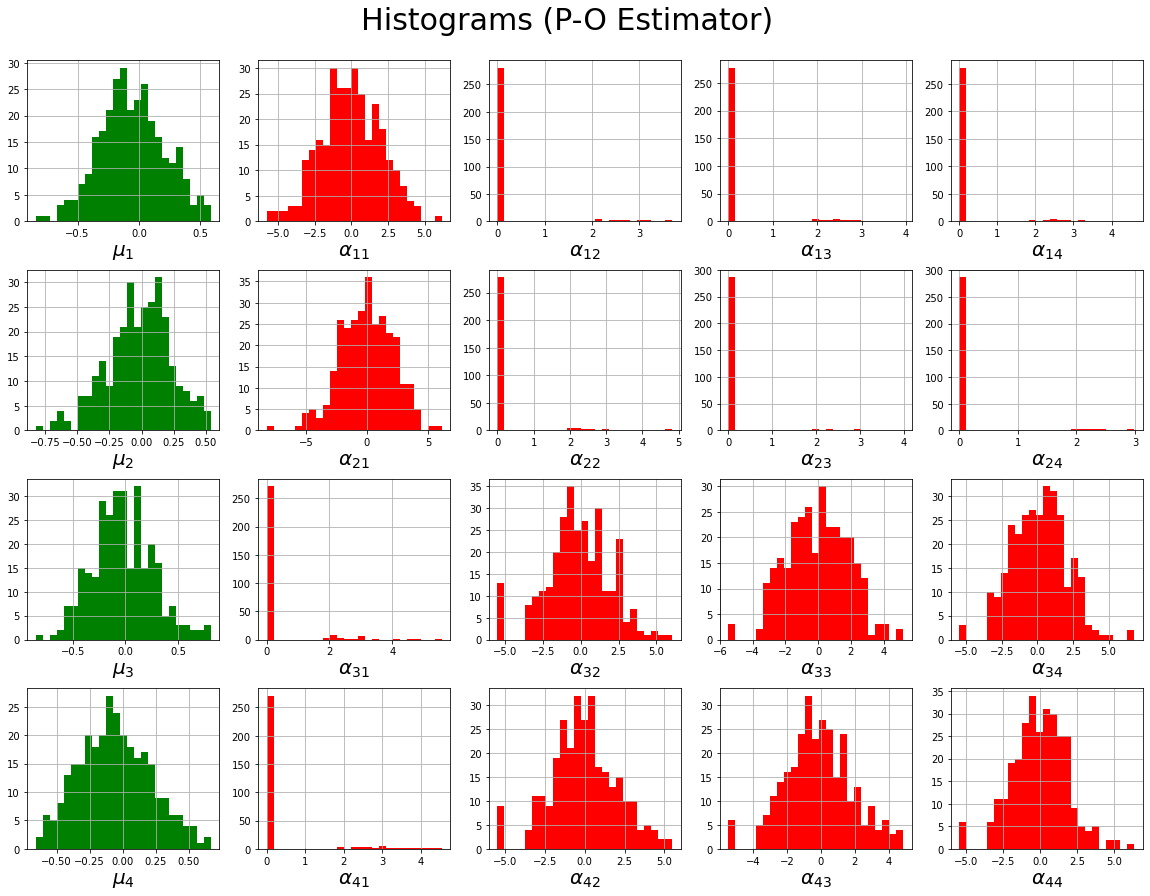

In [12]:
print("●Percentage of estimated to be zero.")
print("mle")
NumOfZero(mleList)
print("poe")
NumOfZero(poeList)
print("\n●Average of squared errors.")
print("mle")
SquaredError(mleList, paramsVector)
print("poe")
SquaredError(poeList, paramsVector)

title = r'Histograms (P-O Estimator)'
SavePath = 'POE/Add_POE_AN_T=%d_MC=%d.eps'  %(t_max, MC)
GEMHP_Hist(poeErrorList, dim, title, SavePath)